# Machine Learning Models for stock prediction - non transformation version

# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

## Import data

The data was downloaded from Bloomberg on:
* Exchange rate of Vietnam with its major trading partners: the China and the US
* Precious metal spot price and future price: Gold, Silver, Palladium, Platinum
* Global Stock Indices: Hang Seng Index, Nasdaq 100, Nasdaq Composite, Nikkei 225, SP500, DOJI, Shanghai Shenzhen CSI3000, Shanghai Shenzhen Composite and Singapore Stock Index
* Volatility stock index: VIX Index

The data will be imported from previous EDA session, which has been cleaned.

In [2]:
# Import data
data = pd.read_csv('index_vni_technical.csv')

# Transfer date column to date time
import datetime
data['Date'] = pd.to_datetime(data['Date'], format = '%m/%d/%Y')

# Turn date into index
data.set_index('Date', inplace = True)

In [3]:
data.head()

,Close,Open,Low,High,Volume
Date,,,,,
2023-06-30,1120.18,1125.39,1120.01,1126.33,617526000
2023-06-29,1125.39,1139.42,1125.39,1140.43,906890000
2023-06-28,1138.35,1134.33,1131.86,1140.56,892136000
2023-06-27,1134.33,1132.03,1128.82,1136.49,721995000
2023-06-26,1132.03,1129.38,1119.95,1134.00,1040389000


# Feature Extraction

We will generate the following set of features:
- Price statistics (High-Low, Open-Close, price and volume difference)
- Simple Moving Average
- Exponential Moving Average

In [4]:
# Reversed the data so we calculate the data backward
data = data[::-1]

## Generate features

In [5]:
## Generate simple price features

# Price indicators
data['H-L'] = data['High'] - data['Low'] 
data['O-C'] = data['Close'] - data['Open'] 

# Moving Average
data['3_sma'] = data['Close'].rolling(3).mean()
data['7_sma'] = data['Close'].rolling(7).mean()
data['10_sma'] = data['Close'].rolling(window = 10).mean() 
data['14_sma'] = data['Close'].rolling(14).mean()
data['21_sma'] = data['Close'].rolling(21).mean()
data['30_sma'] = data['Close'].rolling(window = 30).mean()

# Stock volatility
data['5_std']= data['Close'].rolling(5).std() 
data['7_std'] = data['Close'].rolling(7).std()
data['14_std'] = data['Close'].rolling(14).std()

# Volume volatility
data['vol_diff'] = data['Volume'] - data['Volume'].shift(periods = 1)

# Alternative technical indicators
data['Low_diff'] = data['Low'] - data['Low'].shift(periods = 1)
data['High_diff'] = data['High'] - data['High'].shift(periods = 1)
data['Close_diff'] = data['Close'] - data['Close'].shift(periods = 1)
data['Vol_diff'] = data['Volume'] - data['Volume'].shift(periods = 1)
data['Range_diff'] = data['H-L'] - data['H-L'].shift(periods = 1)

In [6]:
## Define 50 days EMA and SMA
# Calculate the SMA
data['50_sma'] = data['Close'].rolling(50).mean()

# Calculate the EMA
data['50_ema'] = data['Close'].ewm(span = 50, adjust = False).mean()

In [7]:
## Define 100 days EMA and SMA
data['100_sma'] = data['Close'].rolling(100).mean()
data['100_ema'] = data['Close'].ewm(span = 100, adjust = False).mean()

In [8]:
# Window length for moving average
length = 14
# Define function to calculate the RSI
def calc_rsi(over: pd.Series, fn_roll) -> pd.Series:
    # Get the daily return
    delta = over.diff()
    # Get rid of the first day NaN
    delta = delta[1:]
    
    # Make the positive gains (up) and negative gains (downs) series
    up, down = delta.clip(lower = 0), delta.clip(upper = 0).abs()
    
    roll_up, roll_down = fn_roll(up), fn_roll(down)
    rs = roll_up / roll_down
    rsi = 100 - (100 / (1 +rs))
    
    # Avoid division-by-zero if 'roll down' is zero
    # This prevents inf and/or nan values:
    rsi[:] = np.select([roll_down == 0, roll_up == 0, True], [100,0, rsi])
    rsi.name = 'rsi'
    
    # Assert range
    valid_rsi = rsi[length -1:]
    assert ((0 <= valid_rsi) & (valid_rsi <= 100)).all()
    
    return rsi

In [10]:
# Calculate RSI using MA of choice
close = data['Close']
# Reminder: Provide ≥ `1 + length` extra data points!
data['rsi_ema'] = calc_rsi(close, lambda s: s.ewm(span=length).mean())
data['rsi_sma'] = calc_rsi(close, lambda s: s.rolling(length).mean())
data['rsi_rma'] = calc_rsi(close, lambda s: s.ewm(alpha=1 / length).mean())  # Approximates TradingView.
data = data.dropna()

In [11]:
def gain(x):
    return((x > 0) * x).sum()
def loss(x):
    return((x < 0) * x).sum()

# Function to calculate MFI
def mfi_function(high, low, close, volume, n = 14):
    typical_price = (high + low + close) / 3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw = True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw = True)
    return (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()

data['mfi'] = mfi_function(data['High'], data['Low'], data['Close'], data['Volume'], 14)

In [13]:
# Calculate the SMA
data['50_sma'] = data['Close'].rolling(50).mean()

# Calculate the EMA
data['50_ema'] = data['Close'].ewm(span = 50, adjust = False).mean()

100 days MA

In [14]:
data['100_sma'] = data['Close'].rolling(100).mean()
data['100_ema'] = data['Close'].ewm(span = 100, adjust = False).mean()

In [15]:
high_low = data['H-L']
high_close = np.abs(data['High'] - data['Close'].shift(1))
low_close = np.abs(data['Low'] - data['Close'].shift(1))

ranges = pd.concat([high_low, high_close, low_close], axis = 1)
true_range = np.max(ranges, axis = 1)

atr = true_range.rolling(14).sum()/14

data['true_range'] = true_range
data['avg_true_range'] = atr

In [16]:
# Calculate the MACD
data['macd'] = (data['Close'].ewm(span = 9, adjust = False).mean()) - (data['Close'].ewm(span = 26, adjust = False).mean())

### Check the features

In [17]:
# Describe statistics
data.describe()

,Close,Open,Low,High,Volume,H-L,O-C,3_sma,7_sma,10_sma,...,50_ema,100_sma,100_ema,rsi_ema,rsi_sma,rsi_rma,mfi,true_range,avg_true_range,macd
count,3986.000000,3986.000000,3986.000000,3986.000000,3.986000e+03,3986.000000,3986.000000,3986.000000,3986.000000,3986.000000,...,3986.000000,3887.000000,3986.000000,3986.000000,3986.000000,3986.000000,3973.000000,3986.000000,3973.000000,3986.000000
mean,736.006252,736.051197,730.904704,740.901177,2.095157e+08,9.996473,-0.044945,735.976035,735.913132,735.876496,...,735.511265,728.656264,735.158534,52.826318,53.120242,52.126286,53.062192,11.319182,11.326611,0.190434
std,304.411400,304.499621,302.008221,306.395283,2.493532e+08,8.455297,8.877335,304.299361,304.081870,303.922291,...,300.462057,299.841612,295.958370,19.127796,20.034674,14.665556,17.609413,8.930248,6.794356,18.342658
min,235.500000,236.570000,234.660000,236.700000,1.340000e+06,0.270000,-68.310000,240.786667,243.034286,243.798000,...,272.982859,290.770200,303.450700,0.932786,0.000000,6.514197,0.000000,0.760000,3.199286,-82.846792
25%,488.932500,488.765000,485.455000,492.747500,4.469275e+07,5.030000,-3.490000,488.384167,488.201786,488.100250,...,487.642785,486.493100,487.555335,38.700042,37.720648,41.563225,40.836120,5.832500,6.718571,-7.400469
50%,615.745000,615.985000,612.070000,620.690000,1.184730e+08,7.420000,0.165000,615.518333,615.439286,614.279500,...,606.825384,593.114100,598.600820,53.448918,53.366894,52.155245,53.917219,8.580000,9.150714,1.820978
75%,973.575000,972.995000,968.150000,977.702500,2.248825e+08,11.790000,4.040000,973.735000,973.993214,975.032750,...,972.956357,971.593300,973.247000,67.373972,69.150152,62.821606,65.545421,13.657500,14.011429,10.090804
max,1528.570000,1534.100000,1524.960000,1536.450000,1.522741e+09,83.750000,58.280000,1526.516667,1515.951429,1510.201000,...,1490.390027,1484.568800,1471.077126,98.194873,99.783862,93.568041,100.000000,83.750000,46.095714,59.628964


In [18]:
# Exclude missing values
data = data.iloc[100:]

# Machine Learning models - Regression

We will perform the test on several models to determine which models will perform best. The models are:
- Linear Regression (include Ridge and Lasso for avoid multicolinearity)
- Decision Trees Regressor
- Gradient Boosting Regressor
- Random Forest Regressors
- XGBoost Regressor
- Support Vector Regressor

## Train test split - 80% for training and 20% for testing

In [20]:
# Define train test split
def train_test_split(df, target):
    # Define train, cv, test time
    train_time = int(round(len(df) * 0.8))
    
    # Define X, y
    X = df.drop(target, axis = 1)
    y = df[target]
    
    # Train test split
    X_train = X.iloc[:train_time]
    X_test = X.iloc[train_time:]
    
    y_train = y.iloc[:train_time]
    y_test = y.iloc[train_time:]
    
    # Print out to check shape
    print(X_train.shape)
    print(X_test.shape)
    
    print(y_train.shape)
    print(y_test.shape)
    
    return X_train, y_train, X_test, y_test

In [21]:
# Train test split the dataset
X_train, y_train, X_test, y_test = train_test_split(data, 'Close')

(3109, 32)
(777, 32)
(3109,)
(777,)


In [23]:
train_time = int(round(len(data) * 0.8))
    
# Define X, y
X = data.drop('Close', axis = 1)
y = data['Close']
    
# Train test split
X_train = X.iloc[:train_time]
X_test = X.iloc[train_time:]
    
y_train = y.iloc[:train_time]
y_test = y.iloc[train_time:]
    
# Print out to check shape
print(X_train.shape)
print(X_test.shape)
    
print(y_train.shape)
print(y_test.shape)

(3109, 32)
(777, 32)
(3109,)
(777,)


In [24]:
# Import scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Prepare models

We will prepare regression models. We will fit on non-tuned models first to see the model, then based on the result, we will perform further hyperparameters tunning if needed

In [25]:
# Import model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [26]:
# Call out object
lr = LinearRegression()
ridge = Ridge(alpha = 0.1)
lasso = Lasso(alpha = 0.1)
dtr = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 10, min_samples_split = 4)
gb = GradientBoostingRegressor()
xgb = XGBRegressor()
rf = RandomForestRegressor(criterion = 'squared_error', max_depth = 10, min_samples_split = 4)
svr = SVR()

# Set models list
models = [lr, ridge, lasso, dtr, gb, xgb, rf, svr]

### Prepare necessary metrics and functions

In [27]:
# Import metrics
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

def rmse(mse):
    rmse = np.sqrt(mse)

In [28]:
# Define evaluate model
def evaluate_model(model, X_train, y_train, X_cv, y_cv):
    # Fit model and obtain result
    model.fit(X_train, y_train)
    y_pred_cv = model.predict(X_cv)
    MAE = mae(y_cv, y_pred_cv)
    MSE = mse(y_cv, y_pred_cv)
    RMSE = rmse(MSE)

    # Store result
    return MAE, MSE, RMSE

## Evaluate model

In [29]:
# Measure performance of models on generated features
# Test with models
col = ['Linear Regression','Ridge','Lasso','Decision Tree','Gradient Boosting','XGBoost','Random Forest', 'SVR']
MAE_cv = []
MSE_cv = []

for model in models:
    MAE, MSE, RMSE = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    MAE_cv.append(round(MAE, 3))
    MSE_cv.append(round(MSE,3))

cv_result = pd.DataFrame(data = [MAE_cv, MSE_cv], columns = [col], index = ['MAE','MSE'])
cv_result.T.sort_values(by = 'MAE')

,MAE,MSE
Linear Regression,0.000,0.000
Ridge,1.920,7.332
Lasso,2.304,8.856
Gradient Boosting,76.473,16441.537
XGBoost,77.793,16387.064
Random Forest,78.724,17170.648
Decision Tree,79.215,16923.703
SVR,391.051,218657.079


In [30]:
## Visualize the top 3 lowest result models

# Refit to obtain model
lr.fit(X_train_scaled, y_train)
ridge.fit(X_train_scaled, y_train)
lr.fit(X_train_scaled, y_train)

# Obtain predictions
lr_pred = lr.predict(X_test_scaled)
ridge_pred = ridge.predict(X_test_scaled)
lasso_pred = lasso.predict(X_test_scaled)

In [31]:
# Obtain index date for prediction
date_index = X_test.index

# Turn prediction into dataframe
lr_pred = pd.DataFrame(data = lr_pred, index = date_index)
ridge_pred = pd.DataFrame(data = ridge_pred, index = date_index)
lasso_pred = pd.DataFrame(data = lasso_pred, index = date_index)

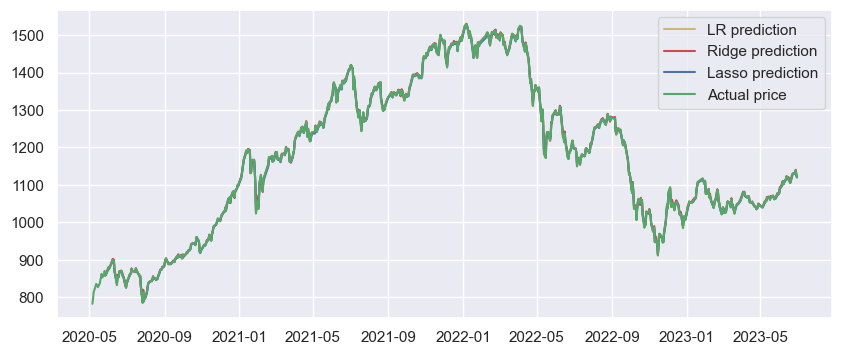

In [32]:
# Plot the visualization
actual = data['Close'].iloc[-791:]

fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(lr_pred, color = 'y', label = 'LR prediction')
ax.plot(ridge_pred, color = 'r', label = 'Ridge prediction')
ax.plot(lasso_pred, color = 'b', label = 'Lasso prediction')
ax.plot(actual, color = 'g', label = 'Actual price')
ax.legend()
plt.show()

The model predicts very well and it seems like global stock indices are not outperformed the predictions of normal technical indicators. Let's take a closer look at shorter timeframe

In [33]:
# Define start and end period
import datetime
start = datetime.datetime(2023,1,1)
end = datetime.datetime(2023,6,30)

# Slicing the frame
actual_slice = actual.loc[start:end]
lr_pred_slice = lr_pred.loc[start:end]
ridge_pred_slice = ridge_pred.loc[start:end]
lasso_pred_slice = lasso_pred.loc[start:end]

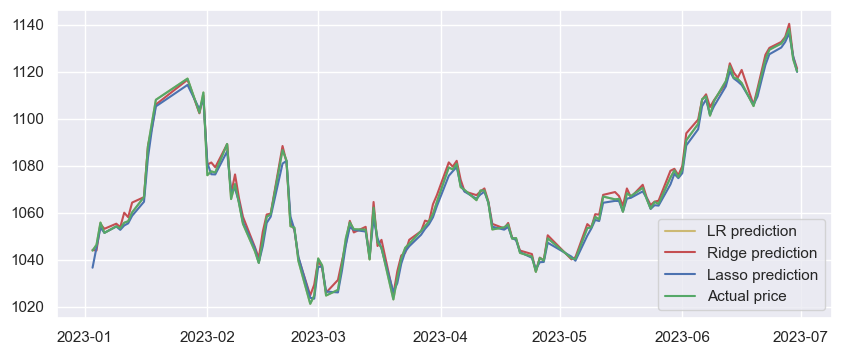

In [34]:
# Plot the visualization
fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(lr_pred_slice, color = 'y', label = 'LR prediction')
ax.plot(ridge_pred_slice, color = 'r', label = 'Ridge prediction')
ax.plot(lasso_pred_slice, color = 'b', label = 'Lasso prediction')
ax.plot(actual_slice, color = 'g', label = 'Actual price')
ax.legend()
plt.show()

The Technical indicators fit well with the actual price movements and has low error.